In [128]:
import emoji
from pythainlp.ulmfit import *
import pandas as pd
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
# import seaborn as sn
import matplotlib.pyplot as plt
import pickle as p
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix, classification_report
from pythainlp.util import normalize

In [129]:
data = pd.read_csv('./dataandpythai_V2.csv', sep=',')
data = data.drop_duplicates(subset=['SentimentText', 'Sentiment'], keep=False)
data = data.reset_index(drop=True)
data = data[['SentimentText','Sentiment']]
data['Sentiment'] = data['Sentiment'].map({0: 'Negative', 1: 'Neutral'})

In [130]:
def text_process(text):
    words = re.sub(r'[^ก-๙]', '', text)
    words = normalize(words)
    words = process_thai(words,
                             pre_rules=[replace_rep_after, fix_html, rm_useless_spaces],
                             post_rules=[ungroup_emoji,
                             replace_wrep_post_nonum,
                             remove_space]
                          )
    words = ' '.join(word for word in words)
    return words
data['SentimentText'] = data['SentimentText'].apply(text_process)
nan_value = float("NaN")
data.replace("", nan_value, inplace=True)
data.dropna(subset = ["SentimentText"], inplace=True)

In [131]:
data.head()

,SentimentText,Sentiment
0,สอบถาม หน่อย ค่ะ ส่ง ของ ไป ชุมพร ได้ ไหม คะ ง...,Neutral
1,เมนูหลัก,Neutral
2,ไม่ แย่,Neutral
5,พึงพอใจ มาก,Neutral
6,บริการ,Neutral


In [132]:
from sklearn.utils import resample, shuffle

data_majority = data[data['Sentiment'] == 'Neutral']
data_minority = data[data['Sentiment'] == 'Negative']

bias = data_minority.shape[0]/data_majority.shape[0]
train = pd.concat([data_majority.sample(frac=0.8,random_state=200),
         data_minority.sample(frac=0.8,random_state=200)])
test = pd.concat([data_majority.drop(data_majority.sample(frac=0.8,random_state=200).index),
        data_minority.drop(data_minority.sample(frac=0.8,random_state=200).index)])

train = shuffle(train)
test = shuffle(test)
print('Neutral data in training:',(train.Sentiment == 'Neutral').sum())
print('negative data in training:',(train.Sentiment == 'Negative').sum())
print('Neutral data in test:',(test.Sentiment == 'Neutral').sum())
print('negative data in test:',(test.Sentiment == 'Negative').sum())

Neutral data in training: 20231
negative data in training: 8622
Neutral data in test: 5058
negative data in test: 2156


In [133]:
max_length = 484
def create_tokenizer(words, filters = ''):
    token = Tokenizer(filters=filters)
    token.fit_on_texts(words)
    return token
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))
def one_hot(encode):
    oh = OneHotEncoder(sparse = False)
    return(oh.fit_transform(encode))

In [134]:
# Separate majority and minority classes in training data for upsampling 
data_majority = train[train['Sentiment'] == 'Neutral']
data_minority = train[train['Sentiment'] == 'Negative']

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
print("After upsampling\n",data_upsampled.Sentiment.value_counts(),sep = "")

majority class before upsample: (20231, 2)
minority class before upsample: (8622, 2)
After upsampling
Neutral     20231
Negative    20231
Name: Sentiment, dtype: int64


In [135]:
train_word_tokenizer = create_tokenizer(data['SentimentText'])
vocab_size = len(train_word_tokenizer.word_index) + 1
encoded_doc = encoding_doc(train_word_tokenizer, data_upsampled['SentimentText'])
unique_category = list(set(data_upsampled['Sentiment']))
output_tokenizer = create_tokenizer(unique_category)
encoded_output = encoding_doc(output_tokenizer, data_upsampled['Sentiment'])
output_one_hot = one_hot(encoded_output)
padded_doc = padding_doc(encoded_doc, max_length)

In [136]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_doc, output_one_hot, test_size = 0.20, random_state = 42, shuffle=True, stratify=output_one_hot)
num_classes = len(unique_category)

In [137]:
adam = Adam(learning_rate=0.0001)
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = True))
  model.add(Bidirectional(LSTM(196), merge_mode='concat'))
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  return model
model = create_model(vocab_size, max_length)
model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

In [138]:
from time import time
start = time()
EPOCHS = 15
BS = 128
filename = './lstm2.h5'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
class_weights = {0: 1, 1: 1.6/bias }
hist = model.fit(X_train, Y_train, epochs = EPOCHS, batch_size = BS, validation_data = (X_test, Y_test), callbacks=[checkpoint, es], class_weight=class_weights)
print(time()-start)

Epoch 1/15
253/253 [==============================] - ETA: 0s - loss: 1.2385 - accuracy: 0.6691
Epoch 00001: val_loss improved from inf to 0.68570, saving model to .\lstm2.h5
253/253 [==============================] - 35s 125ms/step - loss: 1.2385 - accuracy: 0.6691 - val_loss: 0.6857 - val_accuracy: 0.5145
Epoch 2/15
253/253 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.7769
Epoch 00002: val_loss improved from 0.68570 to 0.47050, saving model to .\lstm2.h5
253/253 [==============================] - 31s 122ms/step - loss: 0.7494 - accuracy: 0.7769 - val_loss: 0.4705 - val_accuracy: 0.7754
Epoch 3/15
253/253 [==============================] - ETA: 0s - loss: 0.5633 - accuracy: 0.8317
Epoch 00003: val_loss improved from 0.47050 to 0.39558, saving model to .\lstm2.h5
253/253 [==============================] - 31s 122ms/step - loss: 0.5633 - accuracy: 0.8317 - val_loss: 0.3956 - val_accuracy: 0.8189
Epoch 4/15
253/253 [==============================] - ETA: 0s - l

In [139]:
predict_model = load_model(filename) 
score = predict_model.evaluate(X_test, Y_test, verbose=0)
print('Validate loss:', score[0])
print('Validate accuracy:', score[1])

Validate loss: 0.3677820563316345
Validate accuracy: 0.8727295398712158


In [161]:
def predictions(text):
  text = normalize(text)  
  test_word = process_thai(text,
                             pre_rules=[replace_rep_after, fix_html, rm_useless_spaces],
                             post_rules=[ungroup_emoji,
                             replace_wrep_post_nonum,
                             remove_space]
                          )
  test_ls = train_word_tokenizer.texts_to_sequences(test_word)
  print(test_word)
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
  x = padding_doc(test_ls, max_length)
  pred = predict_model.predict(x)
  return pred

def get_final_output(pred, classes):
  predictions = pred[0]
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))
    return classes[i], predictions[i]

In [178]:
text = 'สั่งของจากช็อปปี้กี่บาท'
# text = 'ห่วยแตกกกก'
pred = predictions(text)
res = get_final_output(pred, unique_category)
res

['สั่งของ', 'จาก', 'ช็อป', 'ปี้', 'กี่', 'บาท']
Neutral has confidence = 0.84231126


('Neutral', 0.84231126)

In [142]:
predicted_classes = np.argmax(predict_model.predict(X_test), axis=-1)
y_true = np.argmax(Y_test,axis = 1)
label_dict = output_tokenizer.word_index
label = [key for key, value in label_dict.items()]
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

    negative     0.8873    0.8539    0.8703      4046
     neutral     0.8593    0.8915    0.8751      4047

    accuracy                         0.8727      8093
   macro avg     0.8733    0.8727    0.8727      8093
weighted avg     0.8733    0.8727    0.8727      8093



In [143]:
with open('history_model', 'wb') as file:
    p.dump(hist.history, file)

with open('history_model', 'rb') as file:
    his = p.load(file)

In [144]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
        
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    plotly.offline.iplot(fig, filename='accuracy-loss')
plot_accuracy_and_loss(hist)

In [145]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, predicted_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, predicted_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, predicted_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, predicted_classes)
print('F1 score: %f' % f1)

Accuracy: 0.872730
Precision: 0.859252
Recall: 0.891525
F1 score: 0.875091


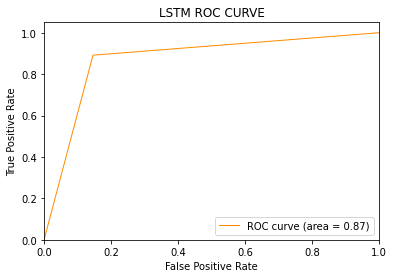

In [146]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, predicted_classes)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM ROC CURVE')
plt.legend(loc="lower right")
plt.show()

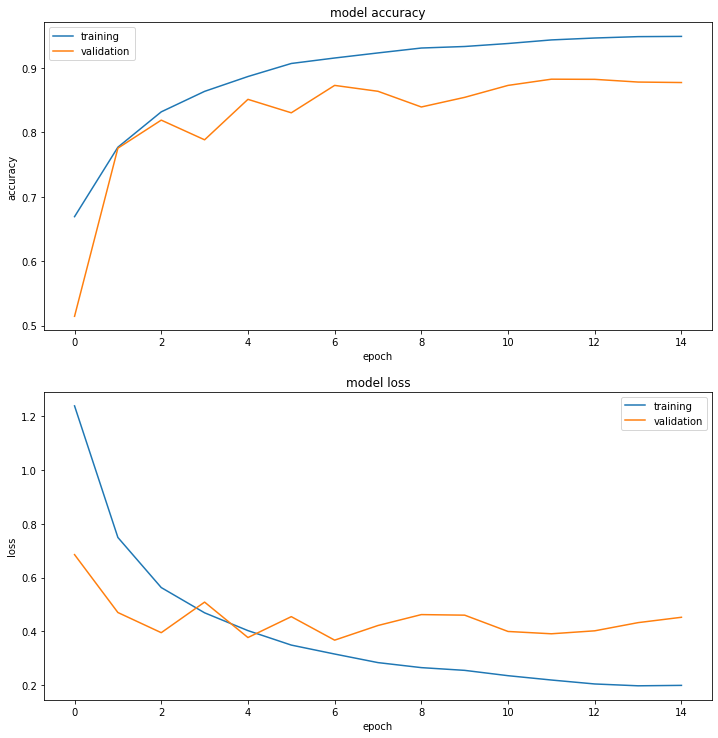

In [147]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(his['accuracy'], his['val_accuracy'], 'accuracy', 211)
display_training_curves(his['loss'], his['val_loss'], 'loss', 212)